In [15]:
import polars as pl
from attack_predictor_libs.dataset.guide_dataset import GuideDataset

In [6]:
dataset = GuideDataset()

In [35]:
df = dataset.data
df = df.with_columns((pl.col("dataset_type") + "_" + pl.col("OrgId").cast(str) + "_" + pl.col("IncidentId").cast(str)).alias("unique_id"))
df = df.drop_nulls("IncidentGrade")

In [46]:
pivot_df = df.pivot(
    index = "unique_id",
    values = "IncidentGrade",
    on = "IncidentGrade",
    aggregate_function = "count"
).fill_null(0)

/tmp/ipykernel_580552/2464090380.py:1: DeprecationWarning: `aggregate_function='count'` input for `pivot` is deprecated. Please use `aggregate_function='len'`.
  pivot_df = df.pivot(


In [48]:
pivot_df.head()

unique_id,FalsePositive,BenignPositive,TruePositive
str,u32,u32,u32
"""train_809_58352""",17,0,0
"""train_11_417400""",4,0,0
"""train_2119_6622""",0,23,0
"""train_261_110412""",0,10,0
"""train_51_84683""",0,5,0


In [54]:
pivot_df = pivot_df.with_columns(
    (pl.col("FalsePositive").cast(pl.Int32) + pl.col("TruePositive").cast(pl.Int32) + pl.col("BenignPositive").cast(pl.Int32)).alias("total"),
).with_columns(
    (pl.col("FalsePositive").cast(pl.Int32)/ pl.col("total")).alias("FalsePositiveRate"),
    (pl.col("TruePositive").cast(pl.Int32)/ pl.col("total")).alias("TruePositiveRate"),
    (pl.col("BenignPositive").cast(pl.Int32)/ pl.col("total")).alias("BenignPositiveRate"),
)

In [68]:
sorted_pivot = pivot_df.sort("FalsePositiveRate", descending = True)

In [80]:
sorted_pivot.shape

(355584, 8)

<BarContainer object of 10000 artists>

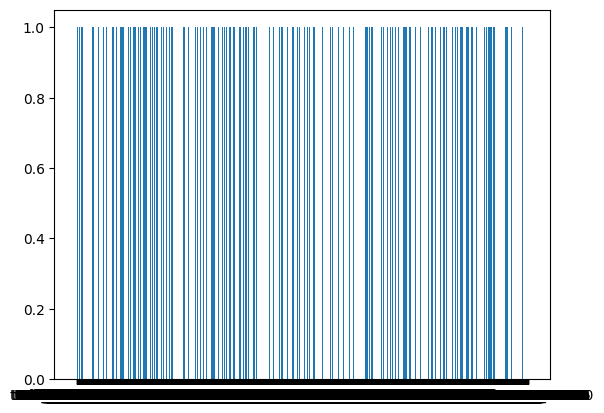

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# .to_pandas().plot(kind = "bar", x = "unique_id", y = ["FalsePositiveRate", "TruePositiveRate", "BenignPositiveRate"], stacked = True)
# ヒストグラム用のバケット
bins = 20

# ヒストグラムを計算
hist, bin_edges = np.histogram(data, bins=bins)

# 棒グラフを作成
plt.bar(bin_edges[:-1], hist, width=(bin_edges[1] - bin_edges[0]))
plt.show()

['train_809_58352',
 'train_11_417400',
 'train_4_2640',
 'train_206_251904',
 'train_4_2624']

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 例: データフレームの列
unique_ids = ["ID1", "ID2", "ID3"]  # X軸ラベル
false_positive = [1.0, 1.0, 0.0]
true_positive = [0.0, 0.0, 0.0]
benign_positive = [0.0, 0.0, 1.0]

# データを積み上げ棒グラフとしてプロット
width = 0.6  # 棒の幅
x = np.arange(len(unique_ids))

plt.bar(x, false_positive, width, label="FalsePositiveRate", color="red")
plt.bar(x, true_positive, width, bottom=false_positive, label="TruePositiveRate", color="green")
plt.bar(x, benign_positive, width, bottom=np.array(false_positive)+np.array(true_positive), label="BenignPositiveRate", color="blue")

plt.xticks(x, unique_ids)
plt.xlabel("Unique ID")
plt.ylabel("Rate")
plt.title("Stacked Bar Chart for Incident Rates")
plt.legend()
plt.show()

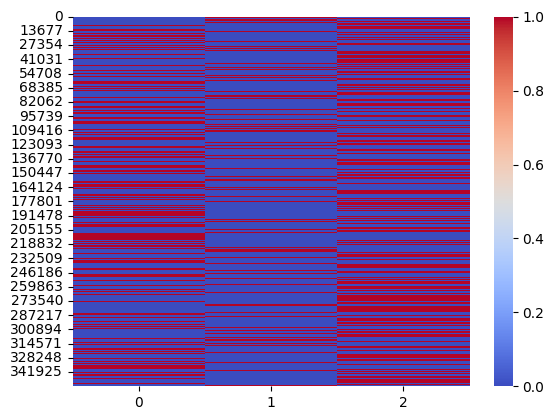

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

# データフレームを整形
# heatmap_data = df.pivot(index="unique_id", columns="IncidentGrade", values="FalsePositiveRate")

# ヒートマップ描画
sns.heatmap(pivot_df.select(["FalsePositiveRate", "TruePositiveRate", "BenignPositiveRate"]), cmap="coolwarm")
plt.show()

In [23]:
df.select(pl.col("unique_id"), pl.col("IncidentGrade"))

unique_id,IncidentGrade
str,str
"""train_809_58352""","""FalsePositive"""
"""train_11_417400""","""FalsePositive"""
"""train_2119_6622""","""BenignPositive"""
"""train_261_110412""","""BenignPositive"""
"""train_51_84683""","""BenignPositive"""
…,…
"""test_358_121968""","""FalsePositive"""
"""test_262_3017""","""BenignPositive"""
"""test_47_3653""","""FalsePositive"""


In [ ]:
df.filtera